In [1]:
import os
import sys
sys.path.append('/home/ubuntu/project')
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import numpy as np
import cv2
import torch

from detectors import DSFD
from facenet_pytorch import MTCNN, InceptionResnetV1
from PIL import Image

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

detection = DSFD(device='cuda', PATH_WEIGHT = '../detectors/dsfd/weights/dsfd_vgg_0.880.pth')

facenet = InceptionResnetV1(pretrained='vggface2').eval().to('cuda')

mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

[DSFD] loading with cuda
[DSFD] finished loading (3.5861 sec)


In [3]:
def process_img(img, box, img_size=160):
    x1, y1, x2, y2, _ = box
    x1 = int(x1)
    y1 = int(y1)
    x2 = int(x2)
    y2 = int(y2)

    img_cropped = img[y1:y2, x1:x2]
    img_cropped = cv2.resize(img_cropped, (img_size, img_size), interpolation=cv2.INTER_AREA)
    img_cropped = (img_cropped - 127.5) /128.0
    img_cropped = torch.tensor(img_cropped, dtype=torch.float32)

    # change (heigth, Width, channel) to (channel, heigth, width)
    img_cropped = img_cropped.permute(2, 0, 1)
    img_cropped = img_cropped.unsqueeze(dim=0).to(device)

    return img_cropped

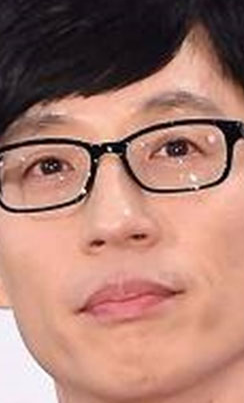

In [6]:
base = '../tmp/base.jpg'

baseimg = cv2.imread(base)
baseimg = cv2.cvtColor(baseimg, cv2.COLOR_BGR2RGB)
box = detection.detect_faces(np.asarray(baseimg), scales=[0.5, 1.0])[0]

x1, y1, x2, y2, _ = box
x1 = int(x1)
y1 = int(y1)
x2 = int(x2)
y2 = int(y2)

crop = baseimg[y1:y2, x1:x2]

img_cropped = process_img(baseimg, box)

display(Image.fromarray(crop))

base = facenet(img_cropped)


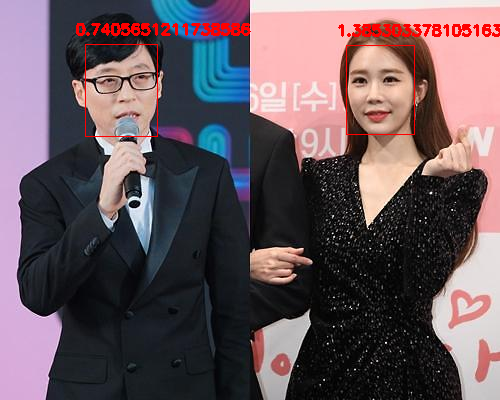

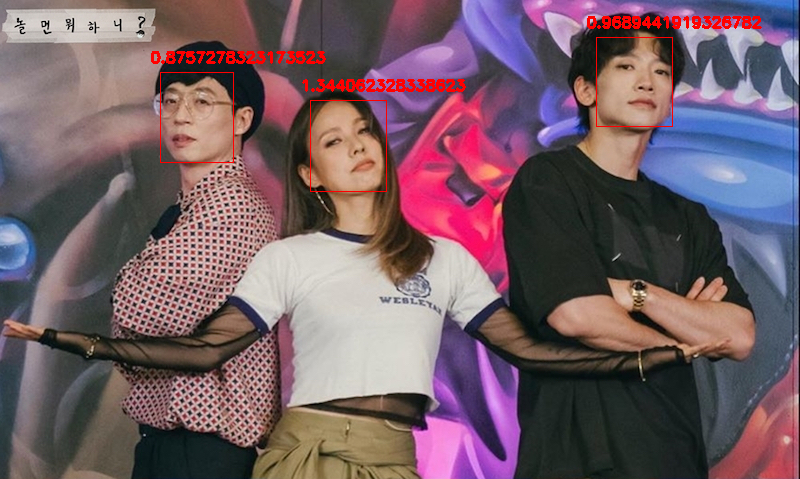

In [9]:
from IPython.display import display

img_paths = ['../tmp/two.jpg', '../tmp/three.jpg']

rgb = (255, 0, 0)

for path in img_paths:

    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    boxes = detection.detect_faces(np.asarray(img), scales=[0.5, 1.0])


    img_processed = img.copy()
    for box in boxes:

        x1 = int(box[0])
        y1 = int(box[1])
        x2 = int(box[2])
        y2 = int(box[3])

        img_cropped = process_img(img, box)

        embed = facenet(img_cropped)

        diff = (base - embed).norm().item()

        img_processed = cv2.putText(img_processed, str(diff), (x1 - 10, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX,0.5, rgb, 2)
        img_processed = cv2.rectangle(img_processed, (x1, y1), (x2, y2), rgb, 1)
    
    display(Image.fromarray(img_processed))
